### PyTorch Workflow
#### What we are going to cover
1. data (prepare and load)
2. build model
3. fitting the model to data (training)
4. making predection and evaluating a model(inference),
5. saving and loading a model
6. putting it all together

In [76]:
import torch
import matplotlib.pyplot as plt
from torch import nn # nn contains all of the pytorch's building blocks for neural networks
torch.__version__

'2.4.1'

## 1. Data (preparing and loading)
Data can be anything .... in machine learning
* Excel spreadsheet
* Images of any kind
* Videos (Youtube and many more)
* Audio like songs or podcasts
* DNA
* Text

#### It has two parts
1. Get data into numerical representation
2. Build a model to learn pattern in that numerical representation

#### To showcase this Let's create a some known data using linea regression formula

In [79]:
# create a known parameters
weight = 0.7
bias = 0.3

#create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [80]:
len(X), len(y)

(50, 50)

### Splitting the data into training, validation set and test set 
* Training Set - (60 to 80)% (always)
* Validation Set - (10 to 20)% (often)
* Testing Set - (10 to 20)% (always)

In [82]:
# Create a train test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [83]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## 2. Data Visualization

In [85]:
#### function to visualize the data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    #""" Plots training data, test data and compare predections. """
    plt.figure(figsize=(10,7))
    
    #plot training data in blue
    plt.scatter(train_data,train_labels, c="b", s=4, label="Training Data")
    #plot test data in green
    
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        #plot the predections in red
        plt.scatter(test_data, predictions, c="r", s=4, label="Predections")
        
    #show the legend
    plt.legend(prop={"size": 14});

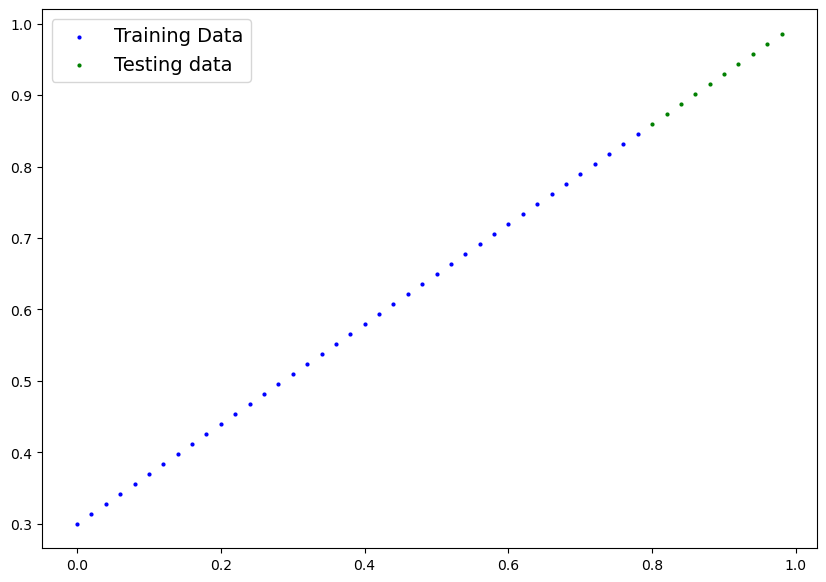

In [86]:
plot_predictions();

### 2.Building the pytorch model

In [88]:
# Creating a linear Regression Model class
from torch import nn
class LinearRegressionModel(nn.Module): #<- almost everything in PyTorch is a nn.module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,dtype=torch.float),
                                    requires_grad=True)
        self.bias = nn.Parameter(torch.rand(1,
                                           dtype=torch.float),
                                 requires_grad=True)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [89]:
# Set manual seed since nn.parameter are randomly initialized
torch.manual_seed(42)

#create the instance os the model
model_0 = LinearRegressionModel()

#check the parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [90]:
# We can also get the state (What the model contains)
# Using state_dict() method

#list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.3904]))])

### Making predections using torch.inference_mode()
Because our model starts with random values, it'll have poor predective power

In [92]:
# Make predections with model
with torch.inference_mode():
    y_preds = model_0(X_test)

### Let's Check predections

In [94]:
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predections made: {len(y_preds)}")
print(f"Predected values:\n{y_preds}")

Number of testing samples: 10
Number of predections made: 10
Predected values:
tensor([[0.6598],
        [0.6665],
        [0.6733],
        [0.6800],
        [0.6867],
        [0.6935],
        [0.7002],
        [0.7069],
        [0.7137],
        [0.7204]])


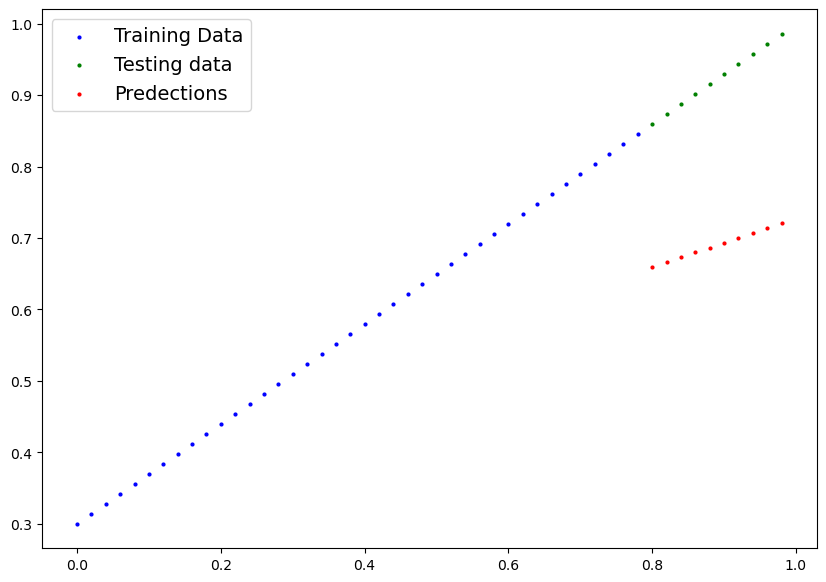

In [95]:
plot_predictions(predictions=y_preds)

## 3. Train Model
Right now this model is just guessing randomly
To fix that, we can update its internal parameters, the weights and bias values we set randomly using nn.parameters() and torch.rand() to be something that better represents

We already know the value of parameters but let's see can the model figure out that value

### Creating a loss function and optimizer in PyTorch
For our model to update its parameters on its own, we'll need to add a few more things to out receipe and they are
* Loss Function
* Optimizer

### Choosing the loss function and optimizer
Since we are predecting a number, so lets use MAE(Mean Absolute Error) which is under **torch.nn.L1Loss()** in PyTorch as our loss function

We'll use SGD(Stochastic Gradient Descent) as our optimizer which is under **torch.optim.SGD(params, lr)** where:
* params is the target model parameters you'd like to optimize(e.g. weights and bias)
* lr is the **learning rate** you'd  like the optimizer to update the parameters 

In [99]:
# create the loss function
loss_fn = nn.L1Loss() #MAE 

#create optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Creating an optimization loop in PyTorch
#### PyTorch training loop
For training loop, we'll build the following thw steps
1. **Forward pass**
2. **Calculate the loss**
3. **Zero gradients**
4. **Perform backpropagation on the loss**
5. **Update the optimizer**

### PyTorch testing loop
1. **Forward pass**
2. **Calculate the loss**
3. **Calculate evaluation metrics**

In [102]:
# Let's train our model for 100 epochs and we'll evaluate it every 10 epochs
torch.manual_seed(42)
epochs = 100

#create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []
for epoch in range(epochs):
    # Training
    
    #put the model in training mode
    model_0.train()
    
    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Progress the optimizer
    optimizer.step()
    
    ### Testing
    #Put the model into evaluation mode
    model_0.eval()
    with torch.inference_mode():
        #1. Forward pass on test data
        test_pred = model_0(X_test)
        
        #2. Calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        
        #print put what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())  #convert a tensor to a NumPy array
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.08169572055339813 | MAE Test Loss: 0.22662055492401123
Epoch: 10 | MAE Train Loss: 0.06808149069547653 | MAE Test Loss: 0.1807345449924469
Epoch: 20 | MAE Train Loss: 0.06258393079042435 | MAE Test Loss: 0.15627031028270721
Epoch: 30 | MAE Train Loss: 0.05879194289445877 | MAE Test Loss: 0.1418602615594864
Epoch: 40 | MAE Train Loss: 0.05530194193124771 | MAE Test Loss: 0.13084018230438232
Epoch: 50 | MAE Train Loss: 0.051822252571582794 | MAE Test Loss: 0.12050700187683105
Epoch: 60 | MAE Train Loss: 0.04838593676686287 | MAE Test Loss: 0.11223447322845459
Epoch: 70 | MAE Train Loss: 0.044948760420084 | MAE Test Loss: 0.10464880615472794
Epoch: 80 | MAE Train Loss: 0.04152031987905502 | MAE Test Loss: 0.09637625515460968
Epoch: 90 | MAE Train Loss: 0.03808232396841049 | MAE Test Loss: 0.08810374140739441


### We can see that, our error is going down with every epoch let's plot it to find out.

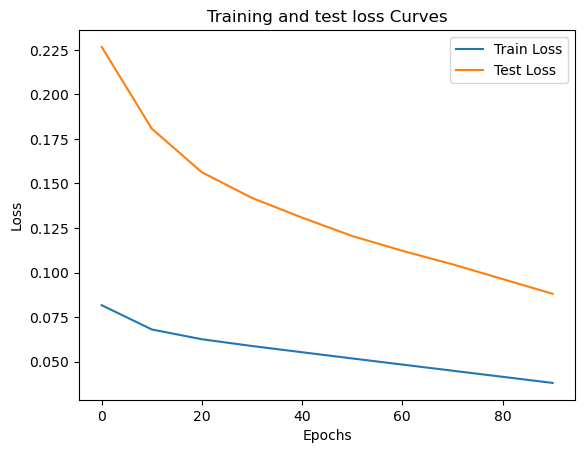

In [104]:
### Plot the loss Curves
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Nice! The loss curves show the loss going down over time, loss is the measure of how wrong your model is, so the lower the better

In [106]:
# Find out the model's learned parameters
print(f"The model learned the following values for weights and the bias: ")
print(model_0.state_dict())
print(f"\nAnd the original values for weights and bias are: ")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and the bias: 
OrderedDict({'weights': tensor([0.5277]), 'bias': tensor([0.3724])})

And the original values for weights and bias are: 
weights: 0.7, bias: 0.3


##### It'd would never guess them perfectly but that's okay, often you can do very cool things with a close approximation.

##### This is the whole idea of machine learning and deep learning, there are some ideal values that describe our data and rather than figuring them out by hand, we can train a model to figure them out programmatically

## 4. Making Predections with a trained PyTorch Model
##### Once a model is trained, We want to make predections with it
##### There are three things to remember when making predections with model
##### 1. Set the model in evaluation model (model.eval())
##### 2. Make the predections using the inference mode context manager(with torch.inference_mode():  ...)
##### 3. All predections should be made with objects on the same device(eg. data and model on GPU only or data and model on CPU only)

In [109]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.7946],
        [0.8051],
        [0.8157],
        [0.8262],
        [0.8368],
        [0.8473],
        [0.8579],
        [0.8684],
        [0.8790],
        [0.8896]])

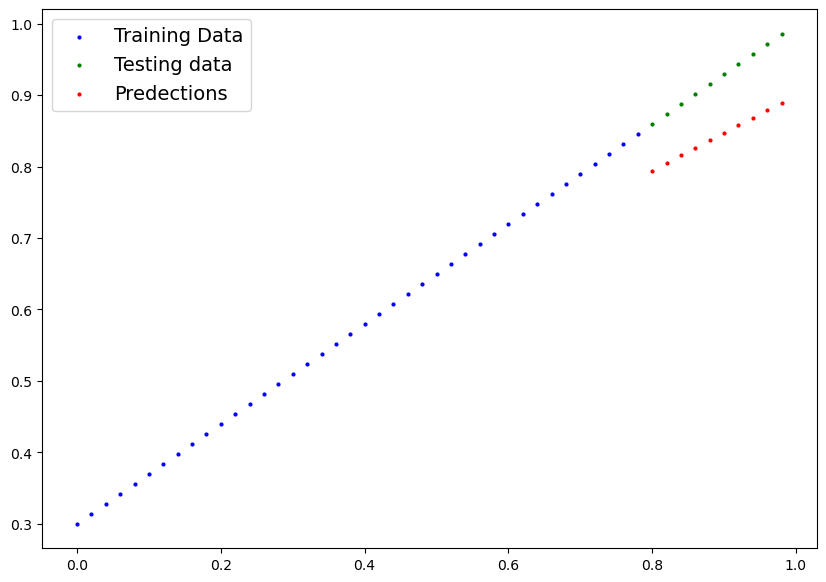

In [110]:
# ploting the predections
plot_predictions(predictions=y_preds)

## 5. Saving and loading a PyTorch model
#### Once you've trained a PyTorch model, chances are you'll want to save it and export it somewhere

### For saving and loading models in PyTorch, there are three main methods:
### 1. torch.save
### 2. torch.load
### 3. torch.nn.Module.load_state_dict

#### Saving a PyTorch model's state_dict()
The recommended way for saving and loading a model for inference(making predections) is by saving and loading a model's state_dict()

##### Let's see how we can do in a few steps:
1. We'll create a directory for saving models to called models using Python's **pathlib** module
2. We'll create a file path to save the model to
3. We'll call **torch.save(obj, f)** where **obj** is the target model's **state_dict()** and **f** is the filename of where to save the model

In [113]:
from pathlib import Path
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create models save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [114]:
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 ritushwar ritushwar 1680 Oct  5 12:41 models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's state_dict()
Once we save the model at path, now we can now load it in using **torch.nn.Module.load_state_dict(torch.load(f))** where **f** is the filepath of our save model **state_dict()**

In [116]:
# Instantiate a new instance of our model
loaded_model_0 = LinearRegressionModel()

#Load the state_dict of our saved model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

/tmp/ipykernel_5574/577267513.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [140]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()
# 2. Use the inference mode content manager to make predections
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [142]:
#compare a previous model woth predections woth loaded model predections
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])